# Bollinger Bands

In [20]:
import pandas as pd
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
plt.style.use(['fivethirtyeight'])

한국거래소에 상장된 주식중 대표격인 삼성전자 주식을 이용해 분석을 시도한다. FinanceDataReader 는 기본적으로 액면분할이 실시간으로 반영된 수정종가(Adjusted Close)를 Close column으로 제공하기에 따로 수정종가를 계산하는 과정이 필요없다.

In [21]:
samsung_df = fdr.DataReader('005930', '2017') # 종목코드와 불러올 데이터의 시작 년도를 파라미터로 하여 불러오기
close_df = samsung_df.loc[:, ['Close']].copy() # 불러온 데이터에서 종가 데이터만 추출

bollinger_band = close_df.copy()
bollinger_band['center band'] =  close_df['Close'].rolling(window=20).mean() # 중간밴드 = 종가
bollinger_band['upper band'] = bollinger_band['center band'] + 2 * close_df['Close'].rolling(window=20).std() # 상단밴드
bollinger_band['lower band'] = bollinger_band['center band'] - 2 * close_df['Close'].rolling(window=20).std() # 하단밴드


생성된 볼린저 밴드를 그래프로 그려서 확인해보자

<AxesSubplot:xlabel='Date'>

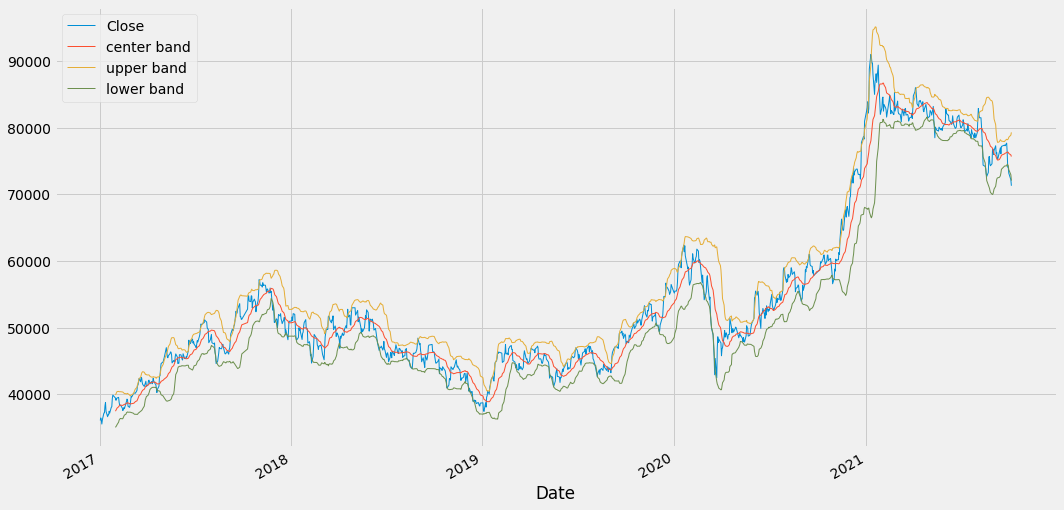

In [22]:

bollinger_band.plot(figsize=(16,9), linewidth=1)

그래프를 보면 Close 가 lower band 를 하향돌파하는 부분이 있다. 그 시점에서 매수, 주식을 홀딩하고 있다가 Close가 upper band를 상향돌파할때 매도를 진행하는 전략을 구현해본다.

매매를 편리하게 기록하고, 백테스팅을 통한 수익을 쉽게 계산하기 위해서는 거래장부를 따로 만들어주는게 좋다. 

In [23]:
book = samsung_df[['Close']].copy()
book['trade'] = ''

이제 트레이딩을 진행한다. book의 trade 컬럼에는 매수, 매도 상태가 저장된다. 'buy'이면 주식을 구매하고 가지고있는 상태, 빈 문자열이면 주식을 가지고 있지 않은 상태이다.

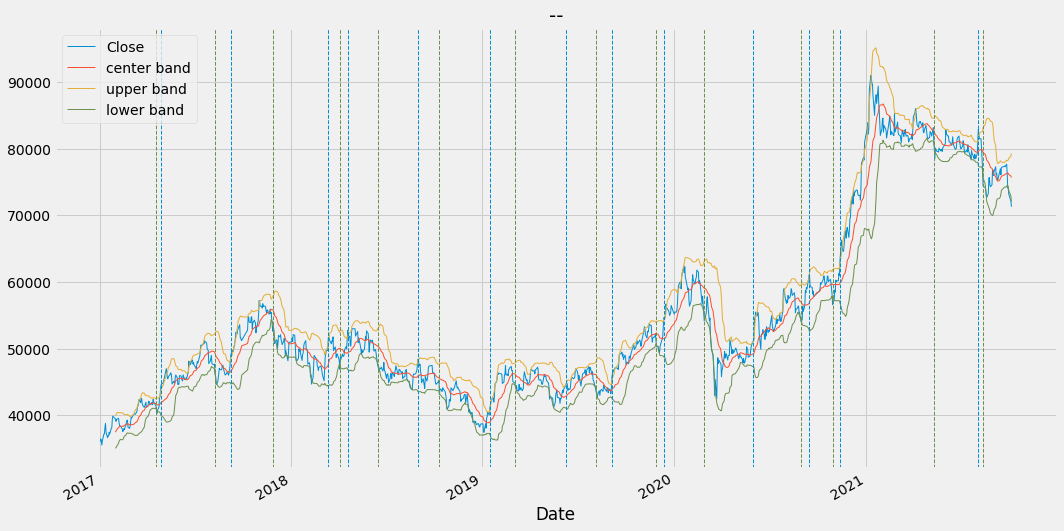

In [24]:
base_date = '2017-02-01'

sliced_bb = bollinger_band.loc[base_date:]
bollinger_band.plot(figsize=(16, 9), title='--', linewidth=1.0)
for i in sliced_bb.index:
    if book.shift(1).loc[i, 'trade'] == 'buy':
        if sliced_bb.loc[i, 'Close'] > sliced_bb.loc[i, 'upper band']:
            book.loc[i, 'trade'] = ''
            plt.axvline(i, linewidth=1, color='C0', linestyle='--', label = 'sell')

        else:
            book.loc[i, 'trade'] = 'buy'
    
    else:
        if sliced_bb.loc[i, 'Close'] < sliced_bb.loc[i, 'lower band']:
            book.loc[i, 'trade'] = 'buy'
            plt.axvline(i, linewidth=1, color='C3', linestyle='--', label = 'buy')


이제 거래결과에 대하여 수익률을 구해본다.

In [32]:
long_return = 1.0 # 매도에 따른 수익률 변수
book['return'] = 1 # 장부에 수익률 컬럼 추가
buy_price = 0.0 # 매수 가격
sell_price = 0.0 # 매도 가격

for i in book.index:
    if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':
        buy_price = book.loc[i, 'Close']
        print('매수일 : ', i.strftime('%Y-%m-%d'), '매수가격 : ', buy_price)
    elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':
        sell_price = book.loc[i, 'Close']
        long_return = (sell_price - buy_price) / buy_price + 1
        book.loc[i, 'return'] = long_return
        print('매도일 : ', i.strftime('%Y-%m-%d'), '매도가격 : ', sell_price, ' | 수익률:', round(long_return*100, 4), '%')

    if book.loc[i, 'trade'] == '':
        buy_price = 0.0
        sell_price = 0.0

acc_return = 1.0 # 총 수익률
for i in book.index:
    rtn = book.loc[i, 'return']
    acc_return = acc_return * long_return
    book.loc[i, 'acc return'] = acc_rtn

print('총 수익률 :', round(100 * acc_rtn, 4), '%')

매수일 :  2017-04-19 매수가격 :  40900
매도일 :  2017-04-27 매도가격 :  43840  | 수익률: 107.1883 %
매수일 :  2017-08-09 매수가격 :  46280
매도일 :  2017-09-08 매도가격 :  49080  | 수익률: 106.0501 %
매수일 :  2017-11-27 매수가격 :  52640
매도일 :  2018-03-13 매도가격 :  51660  | 수익률: 98.1383 %
매수일 :  2018-04-04 매수가격 :  46920
매도일 :  2018-04-19 매도가격 :  52780  | 수익률: 112.4893 %
매수일 :  2018-06-15 매수가격 :  47650
매도일 :  2018-08-31 매도가격 :  48450  | 수익률: 101.6789 %
매수일 :  2018-10-11 매수가격 :  43100
매도일 :  2019-01-15 매도가격 :  41100  | 수익률: 95.3596 %
매수일 :  2019-03-05 매수가격 :  44250
매도일 :  2019-06-10 매도가격 :  44800  | 수익률: 101.2429 %
매수일 :  2019-08-05 매수가격 :  43950
매도일 :  2019-09-05 매도가격 :  45700  | 수익률: 103.9818 %
매수일 :  2019-11-29 매수가격 :  50300
매도일 :  2019-12-13 매도가격 :  54700  | 수익률: 108.7475 %
매수일 :  2020-02-28 매수가격 :  54200
매도일 :  2020-06-01 매도가격 :  51200  | 수익률: 94.4649 %
매수일 :  2020-08-31 매수가격 :  54000
매도일 :  2020-09-14 매도가격 :  60400  | 수익률: 111.8519 %
매수일 :  2020-10-30 매수가격 :  56600
매도일 :  2020-11-13 매도가격 :  63200  | 수익률: 111.6608 %
매수일 :  

참고문헌: '퀀트전략을 위한 인공지능 트레이딩, 김태헌 신준호, 2020'